# MNIST

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from the readily available tfdataset by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml
import matplotlib.pyplot as plt

## Create Datasets

In [3]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "mnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed"
    },
}

In [4]:
# create the datasets based on the above defined names/splits/specifed data
ds_dict_raw = dd.read(dd_dict)

root dir set to None


## alter dataset

In [5]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

In [6]:
for k, cur_ds in ds_dict_raw.items():
    
    cur_ds = cur_ds.map(
            normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

    ds_dict_raw[k] = cur_ds

In [7]:
ds_dict = {"mnist": ds_dict_raw}

`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## Specify the Model

In [8]:
# %load_ext autoreload
# %autoreload 2
# import yeahml as yml

In [9]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

In [10]:
#yml_dict

## Build the model

In [11]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_image (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv_2_downsample (Conv2D)   (None, 14, 14, 8)         584       
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 8)         584       
_________________________________________________________________
conv_4_downsample (Conv2D)   (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576 

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [13]:
ds_dict

{'mnist': {'train': <ParallelMapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <ParallelMapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <ParallelMapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>}}

In [14]:
%%time
# roughly 69 seconds vs 116 seconds 5 epoch mnist -- not a real benchmark (23April19)
# roughly 69 seconds vs 101 seconds 5 epoch mnist -- not a real benchmark (24April19)
train_dict = yml.train_model(model, yml_dict, ds_dict)

train_logger: INFO     -> START training graph
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 1
train_logger: INFO     done validation - 45000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 2
train_logger: INFO     done validation - 90000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 3
train_logger: INFO     done validation - 135000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 4
train_logger: INFO     done validation - 180000
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     main_opt removed from list of opt. remaining: []
train_logger: INFO     is_training: False

CPU times: user 3min 58s, sys: 22.8 s, total: 4min 21s
Wall time: 1min 41s


In [15]:
def plot_trackers(tracker, skip=0):
    plt.plot(tracker.steps[skip:], tracker.values[skip:], 'o--', linewidth=2, markersize=5)

In [16]:
print(train_dict["tracker"]["main_opt"]["main_obj"]["loss"]["mnist"]["val"]["sparse_categorical_crossentropy"]["mean"])

<class 'yeahml.train.setup.tracker.tracker.Tracker'>: {'to_track': ['min'], 'values': [0.3272859, 0.26777926, 0.23449495, 0.21478711, 0.20153923], 'steps': [45000, 90000, 135000, 180000, 225000], 'min': 0.20153923, 'step_at_min': 225000}


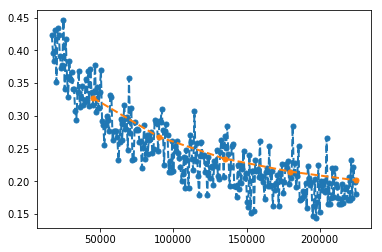

In [17]:
plot_trackers(train_dict["tracker"]["main_opt"]["main_obj"]["loss"]["mnist"]["train"]["sparse_categorical_crossentropy"]["mean"], 20)
plot_trackers(train_dict["tracker"]["main_opt"]["main_obj"]["loss"]["mnist"]["val"]["sparse_categorical_crossentropy"]["mean"], 0)

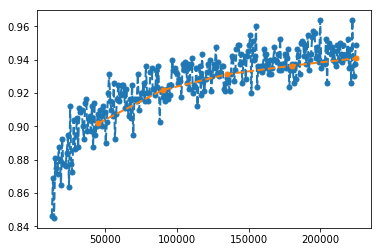

In [18]:
plot_trackers(train_dict["tracker"]["main_opt"]["main_obj"]['metrics']["mnist"]["train"]['sparsecategoricalaccuracy'], 15)
plot_trackers(train_dict["tracker"]["main_opt"]["main_obj"]['metrics']["mnist"]["val"]['sparsecategoricalaccuracy'])

## Evaluate the Model

In [18]:
eval_dict = yml.eval_model(
    model,
    yml_dict,
    dataset=ds_dict["test"]
)
print(eval_dict)

ValueError: specified path is neither an h5 path, nor a directory containing directories of h5: yeahml/abalone/trial_00/model/run_2020_03_15-14_02_15/save/params/best_params.h5

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```